<a href="https://colab.research.google.com/drive/1tElT3FhddabqCyJKFH27rhnyXJTqrzke?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [166]:
import pandas as pd
import numpy as np

In [168]:
all_data = pd.read_csv('forest_dataset.csv')
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [170]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

In [172]:
from sklearn.model_selection import train_test_split

In [174]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
clf.fit(train_feature_matrix, train_labels);

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [179]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_neighbors': np.arange(1, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean'],
}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels);

Let's output the best parameters

In [182]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [185]:
optimal_clf = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='manhattan')
optimal_clf.fit(train_feature_matrix, train_labels)
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

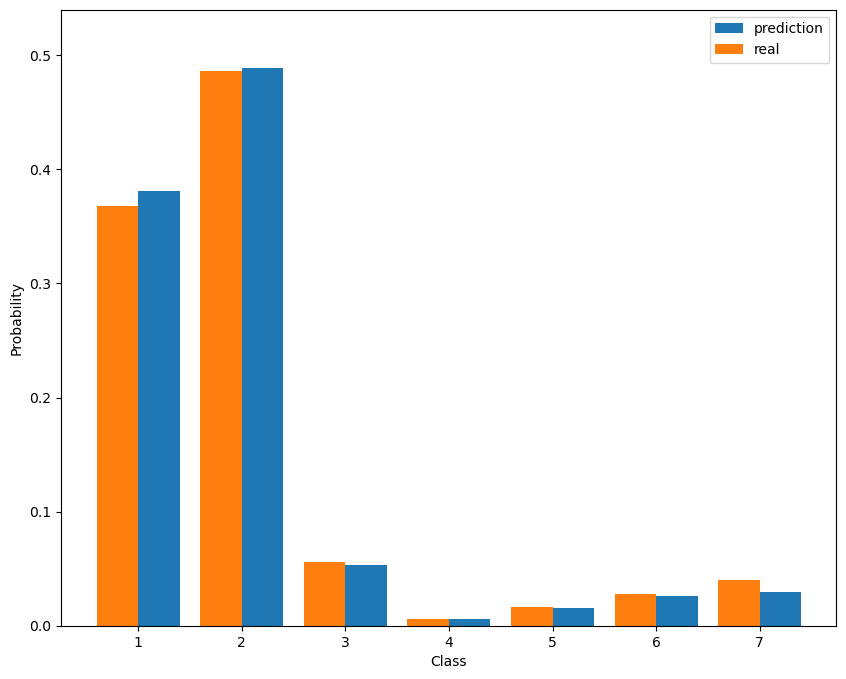

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [189]:
accuracy_knn = accuracy_score(test_labels, optimal_clf.predict(test_feature_matrix))
accuracy_knn

0.785

In [191]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
train_feature_matrix_scaled = scaler.fit_transform(train_feature_matrix)
test_feature_matrix_scaled = scaler.transform(test_feature_matrix)

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(train_feature_matrix_scaled, train_labels)

score_log_regr = logistic_regression.score(test_feature_matrix_scaled, test_labels)
score_log_regr

0.719

Нельзя однозначно сказать, какая модель луше. Выбор между логистической регрессией и kNN зависит от конкретной задачи, характеристик данных и приоритетов. kNN может быть предпочтительнее, когда объем обучающих данных небольшой, данные имеют нелинейную стуруктуру. Модель логистической регрессии может быть предпочтительнее, если данные линейно разделимы, требуется быстрое предсказание.

**Плюсы kNN:**
* Идея алгоритма kNN интуитивно понятна
* kNN можно использовать и для классификации, и для регрессии
* Обучение kNN очень быстрое, так как он просто запоминает обучающую выборку

**Минусы kNN:**
* Высокая вычислительная стоимость во время предсказания. Для каждого нового объекта необходимо вычислить расстояние до всех объектов обучающей выборки, отсортировать расстояния и найти k ближайших соседей
* Чувствителен к шуму и выбросам в данных
* Выбор оптимального значения параметра k требует экспериментального подбора с использованием кросс-валидации

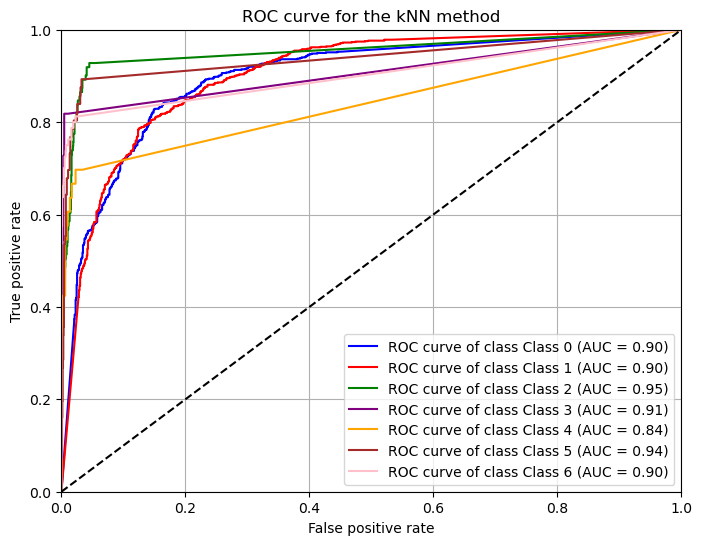

In [227]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = len(np.unique(labels))
test_labels_bin = label_binarize(test_labels, classes=np.unique(labels))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (AUC = {1:.2f})'.format(f'Class {i}', roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for the kNN method')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Для любого класса ROC кривая проходит выше диагонали, поэтому наша модель предсказывает лучше случайного угадывания 